### Putting It All Together Chapter 5. Time Series Analysis

#### 1 :Cointegration Models

The idea behind cointegration is  that even if the prices of two different assets both follow random walks, it is still possible that a linear combination of them is not a random walk. If that's true, then even though P and Q are not forecastable because they're random walks, the linear combination is forecastable, and we say that P and Q are cointegrated.


- What is Cointegration?
    - Two series, $P_t$ and $Q_t$ can be random walks
    - But the linear combination $P_t - c Q_t$ may not be a random walk!
    - If that's true
        - $P_t - c Q_t$ is forecastable
        - $P_t$ and $Q_t$ are said to be cointegrated
- Analogy: Dog on a Leash
    - $P_t =$ Owner
    - $Q_t =$ Dog
    - Both series look like a random walk
    - Difference of distance between them, looks mean reverting
        - If dog falls too far behind, it gets pulled forward
        - If dog gets too far ahead, it gets pulled back
- What types of series are cointegrated?
    - Economic substitutes
        - Heating Oil and Natural Gas
        - Platinum and Palladium
        - Corn and Wheat
        - Corn and Sugar
        - $\dots$
        - Bitcoin and Ethereum
- Two steps to test for Cointegration
    - Regress $P_t$ on$Q_t$ and get slope $c$
    - Run Augmented Dickey-Fuller test on $P_t - c Q_t$ to test for random walk
    - Alternatively, can use ```coint``` function in statsmodels that combines both steps

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 5)
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
import datetime

In [3]:
HO = pd.read_csv('./dataset/CME_HO1.csv', index_col=0)
NG = pd.read_csv('./dataset/CME_NG1.csv', index_col=0)

In [4]:
HO.index = pd.to_datetime(HO.index, format='%m/%d/%Y')
NG.index = pd.to_datetime(NG.index, format='%m/%d/%Y')

In [5]:
HO = HO.sort_index()
NG = NG.sort_index()

In [6]:
HO.head()

,Close
Date,
1991-01-02,0.7330
1991-01-03,0.7024
1991-01-04,0.6830
1991-01-07,0.7617
1991-01-08,0.7430


#### 1 A: A Dog on a Leash? (Part 1)
The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in $/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from Quandl.

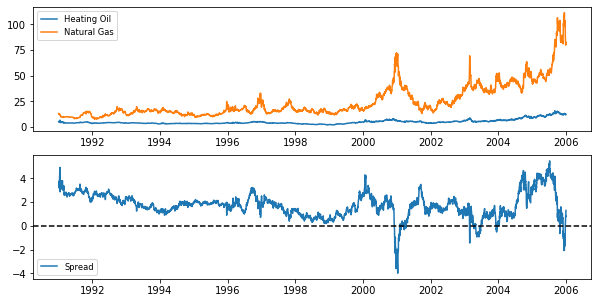

In [8]:
# Plot Heating Oil, HO, and Natural Gas, NG, on the same subplot
plt.subplot(2, 1, 1)
# Make sure you multiply the HO price by 7.25 to match the units of NG
plt.plot(7.25 * HO, label="Heating Oil");
plt.plot(7.25 * NG, label="Natural Gas")
plt.legend(loc="best", fontsize="small");

# Plot the spread on a second subplot
plt.subplot(2, 1, 2)
# The spread will be 7.25*HO - NG
plt.plot(7.25 * HO - NG, label="Spread")
plt.legend(loc="best", fontsize="small")
plt.axhline(y=0, linestyle="--", color="k")
plt.show()


 note: Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.

#### 1: B -  A Dog on a Leash? (Part 2)
To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

In [11]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Perform the adfuller test on HO and on NG separately, and save the results (results are a list)
# The argument for adfuller must be a series, so you need to include the column 'Close'
result_HO = adfuller(HO["Close"])

# Print just the p-value (item [1] in the list)
print('The p-value of the test on prices HO  is: ' + str(result_HO[1]))
print("test statistic : "  + str(result_HO[0]))


result_NG = adfuller(NG["Close"])
print('The p-value of the test on prices NG is: ' + str(result_NG[1]))
print("test statistic : "  + str(result_NG[0]))


# Do the same thing for the spread, again converting the units of HO, and using the column 'Close' of each DataFrame

result_spread = adfuller(7.25 * HO["Close"] - NG["Close"])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value of the test on prices HO  is: 0.9567108785017863
test statistic : -0.021577136887493267
The p-value of the test on prices NG is: 0.9008747444676728
test statistic : -0.4529547967000908
The p-value for the ADF test on the spread is  7.019439302142287e-05


note:  As we expected, we cannot reject the hypothesis that the individual futures are random walks, but we can reject that the spread is a random walk.

####  1 C: Are Bitcoin and Ethereum Cointegrated?
Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,−1). In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call 

In [12]:
BTC = pd.read_csv('./dataset/BTC.csv', index_col=0)
ETH = pd.read_csv('./dataset/ETH.csv', index_col=0)

In [14]:
BTC.head()

,Price
Date,
2015-09-29,236.9
2015-09-30,237.1
2015-10-01,238.3
2015-10-02,238.3
2015-10-03,239.9


In [13]:
BTC.index = pd.to_datetime(BTC.index, format='%Y-%m-%d')
ETH.index = pd.to_datetime(ETH.index, format='%Y-%m-%d')

In [20]:
# Import the statsmodels module for regression and the adfuller function
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Add a constant to the ETH DataFrame using sm.add_constant()
ETH = sm.add_constant(ETH)

# Regress BTC on ETH using sm.OLS(y,x).fit(), where y is the dependent variable and x is the independent variable, and save the results in result.

result = sm.OLS(BTC, ETH).fit()

# The intercept is in result.params[0] and the slope in result.params[1]
# Run ADF test on BTC  ETH
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b * ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.023369002323472794


note :The data suggests that Bitcoin and Ethereum are cointegrated.

### Case Study: Climate Change 
 
- #### Analyzing Temperature Data
Dickey-Fuller test to see whether the data is a Random Walk. Then, you'll take first differences of the data to transform it into a stationary series, and compute the Autocorrelation Function and the Partial Autocorrelation Function of the data. Using that as a guide, you'll fit a few AR, MA, and ARMA models to the data. Then you'll use the Information Criterion to choose the best model among the ones you looked at. Finally, with the best model, you'll forecast temperatures over the next 30 years.

The data was downloaded from the NOAA website. 

 #### 2 A - : Is Temperature a Random Walk (with Drift)?
An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame ```temp_NY``` contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA [here](https://www.ncdc.noaa.gov/cdo-web/search)). Plot the data and test whether it follows a random walk (with drift).

In [45]:
temp_NY = pd.read_csv("./dataset/NOAA_TAVG.csv", index_col=0)
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')
temp_NY.head()

,TAVG
DATE,
1870-01-01,53.8
1871-01-01,51.3
1872-01-01,51.3
1873-01-01,50.9
1874-01-01,51.3


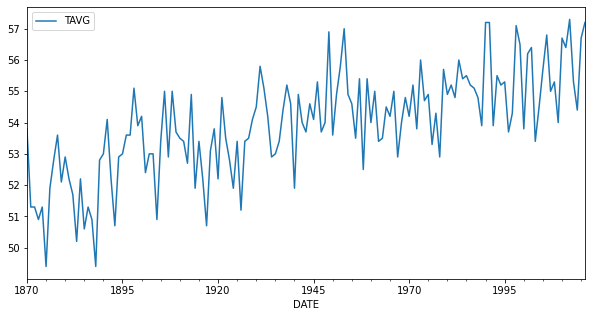

The p-value for the ADF test is  0.583293898787111


In [46]:
# Convert the index of years into a datetime object using pd.to_datetime(), and since the data is annual, pass the argument format='%Y'.
# Plot the data using .plot()
temp_NY.plot()
plt.show()

# Compute the p-value the Augmented Dickey Fuller test using the adfuller function.
result = adfuller(temp_NY["TAVG"])
# Save the results of the ADF test in result, and print out the p-value in result[1].
print("The p-value for the ADF test is ", result[1])

note : We cannot reject the null hypothesis as the p-value is greater than 0.5. The data seems to follow a random walk with drift.

#### 2: B -  Getting "Warmed" Up: Look at Autocorrelations
Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model


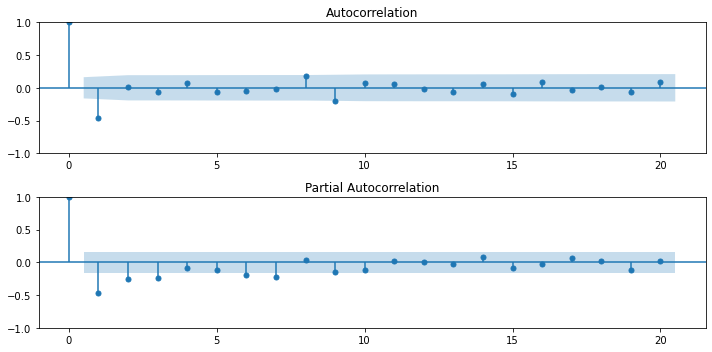

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2, 1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0]);

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1]);

plt.tight_layout()

note: There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF.

#### 2: C Which ARMA Model is Best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

The annual change in temperature is in a DataFrame chg_temp.

In [61]:
# For each ARMA model, create an instance of the ARMA class, passing the data and the order=(p,q). 
    #p is the autoregressive order; q is the moving average order.
# Fit the model using the method .fit().
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Print the AIC value, found in the .aic element of the results.  
mod_ma1 = ARIMA(chg_temp, order=(0, 0, 1))
res_ma1 = mod_ma1.fit()
print("The AIC for an MA(1) is: ", res_ma1.aic)
        

The AIC for an AR(1) is:  510.5346898733107
The AIC for an AR(2) is:  501.92741234091386
The AIC for an MA(1) is:  469.3909780330102


note: The ARIMA(1,1) MA(1) ,has the lowest AIC values among the three models.

#### 3: D-  Don't Throw Out That Winter Coat Yet
Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

The data is preloaded in a DataFrame called temp_NY.

In [64]:
# Create an instance of the ARIMA class called mod for an integrated ARMA(1,1) model
# The d in order(p,d,q) is one, since we first differenced once
mod = ARIMA(chg_temp, order=(1, 1, 1))
# Fit mod using the .fit() method and call the results res
res = mod.fit()

# Forecast the series using the plot_predict() method on res
# Choose the start date as 1872-01-01 and the end date as 2046-01-01


![](img17.png)

 note : According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.